In [179]:
### Libraries ###
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import interp1d
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

1. Write a Monte Carlo simulation that generates scattering events following the distributions found analytically; 
2. Produce a synthetic dataset of about $N=10^5$ (or more) events. Events should be expressed as rows in a file with columns representing the muons coordinates;
3. Assume a $3$ cm thick Beryllium block is used as a target, and the rate of positrons on the target is $10^6$ Hz. Compute a rescaling factor (weight) you need to apply to each one of the $N$ simulated events such that they represent the statistics that would be gathered in a week of countinuous operations.

In [205]:
## Constants ##

alpha  = 1 / (137.035999084) #  Fine-Structure constant
mu = 105.6583755       # [MeV] Muon mass
me    = 0.51099895        # [MeV] Electron mass
sqr_s      = 250.          # [MeV] Invariant mass  
N =   10**5               # number of muons pair

In [181]:
#Definition of functions

""" Kinematic's formula  """
def b_mu(s):
    return (1 - 4*mu**2/s)**0.5

def b_me(s):
    return (1 - 4*me**2/s)**0.5

def norm(s):
    return (s/4 - mu**2)**0.5

def tan_lab(theta):
    return np.sin(theta) * (1 - b_me(s))**0.5 / (np.cos(theta) + b_me(s)/b_mu(s)) 

def boost_e(s, px):
    return (1 - b_me(s))**0.5 * s + b_me(s) *( 1 - b_me(s))**0.5 * px

def boost_px(s,px):
    return (1 - b_me(s))**0.5 * px + b_me(s) *( 1 - b_me(s))**0.5 * s

""" -----------------------------------------"""

""" Differential cross section formula [MeV^-2 sr^-1] """
def sigma_diff (s,theta):
    return alpha**2/(4*s) * (b_mu(s)/b_me(s)) * (1. + 4.*(me**2 + mu**2)/s + b_me(s)**2 * b_mu(s)**2 * np.cos(theta)**2)

""" Cross section formula [MeV^-2 sr^-1] """
def sigma(s):
    return (4 * alpha**2 * np.pi)/(3 * s**3) * (b_mu(s)/b_me(s)) * (2 * me**2 + s) * (2 * mu**2 + s)

""" Angular distribution formula  """ #Not sure this is the angular distribution formula
def ang(theta):
    return 2 * np.pi * np.sin(theta) * sigma_diff(s,theta) / sigma(s)

# this allows 
def cdf_ang(s,theta):
    return -1/3 * 3/8 * (s**2/((2*me**2+s)*(2*mu**2+s))) * np.cos(theta) * (3 * 4/s * (me**2+mu**2) + b_me(s) * (np.cos(theta))**2 + 3)



# Montecarlo with monochromatic beam

The first simulation of the scattering process is based on a monochromatic positron beam, i.e. it has the following characteristics:
- we assume its transversal section to be point-like;
- all the beam particles have the same energy.

In order to sample $\theta$ distributed according to the differential cross section, we will use the inverse transform method. 
Since we know the analytic form of CDF of the angular distribution in the CoM frame $g(\theta^*)$, this approach can be applied and 
leads to better performances. The distribution $h(\varphi^*)$ is infact uniform in the interval [0,$2\pi$]. Namely we have:

$$
g(\theta^*) = \frac{2\pi \sin(\theta^*)}{\sigma^*} \cdot \frac{\mathrm{d}\sigma^*}{\mathrm{d}\Omega^*} \quad \quad \text{and} \quad \quad h(\varphi^*) = \frac{1}{2\pi}

$$

The CDF is computed through the following: 

\begin{align}
\text{CDF}[ g(\theta^*)]=  \int_0^{\theta^*} g(\theta^*)  \mathrm{d}\theta^*  
= \int_0^{\theta^*} \frac{2\pi \sin(\theta^*)}{\sigma} \cdot \frac{\alpha^2}{4s} \left(1- \frac{4 m_\mu^2}{s}\right)^{1/2} \left(1- \frac{4 m_e^2}{s}\right)^{-1/2}\left[ 1+ \frac{4}{s} (m_e^2 + m_\mu^2) + \left(1-\frac{4 m_e^2}{s}\right)\left(1-\frac{4 m_\mu^2}{s}\right)\cos^2\theta^*\right]  \\ = 
\frac{2\pi}{\sigma} \frac{\alpha^2}{4s} \left(1- \frac{4 m_\mu^2}{s}\right)^{1/2} \left(1- \frac{4 m_e^2}{s}\right)^{-1/2}
    \cdot \left\{\left[1+ \frac{4}{s} (m_e^2 + m_\mu^2)\right] (1 - \cos\theta^*) + \frac{1}{3}\left(1-\frac{4 m_e^2}{s}\right)\left(1-\frac{4 m_\mu^2}{s}\right)(1 - \cos^3\theta^*)\right\} \tag{0.1}
\end{align}

To generate the events:

$a_i$ random uniform in [0,1] $\implies$ CDF[$g(\theta^*)]^{-1}$($a_i$) =$\theta^*_i \\$ 
$b_i$ random uniform in [0,$2\pi$] $\implies$ CDF[$h(\theta^*)]^{-1}$($b_i$) =$\varphi^*_i $

The inverse of the CDF is computed by interpolation through different methods available in the scipy library, i.e. ``UnivariateSpline``, ``InterpolatedUnivariateSpline`` and ``interp1d``.


In [202]:
def g_cdf(s, theta):
    '''CDF for the theta* distribution'''
    
    return (4 * (2 * me**2 + s) * (2 * mu**2 + s) - 3 * s * (4 * me**2 + 4 * mu**2 + s) * np.cos(theta) + (4 * me**2 - s) * (-4 * mu**2 + s) * np.power(np.cos(theta),3)) / \
           (8 * (2 * me**2 + s) * (2 * mu**2 + s))

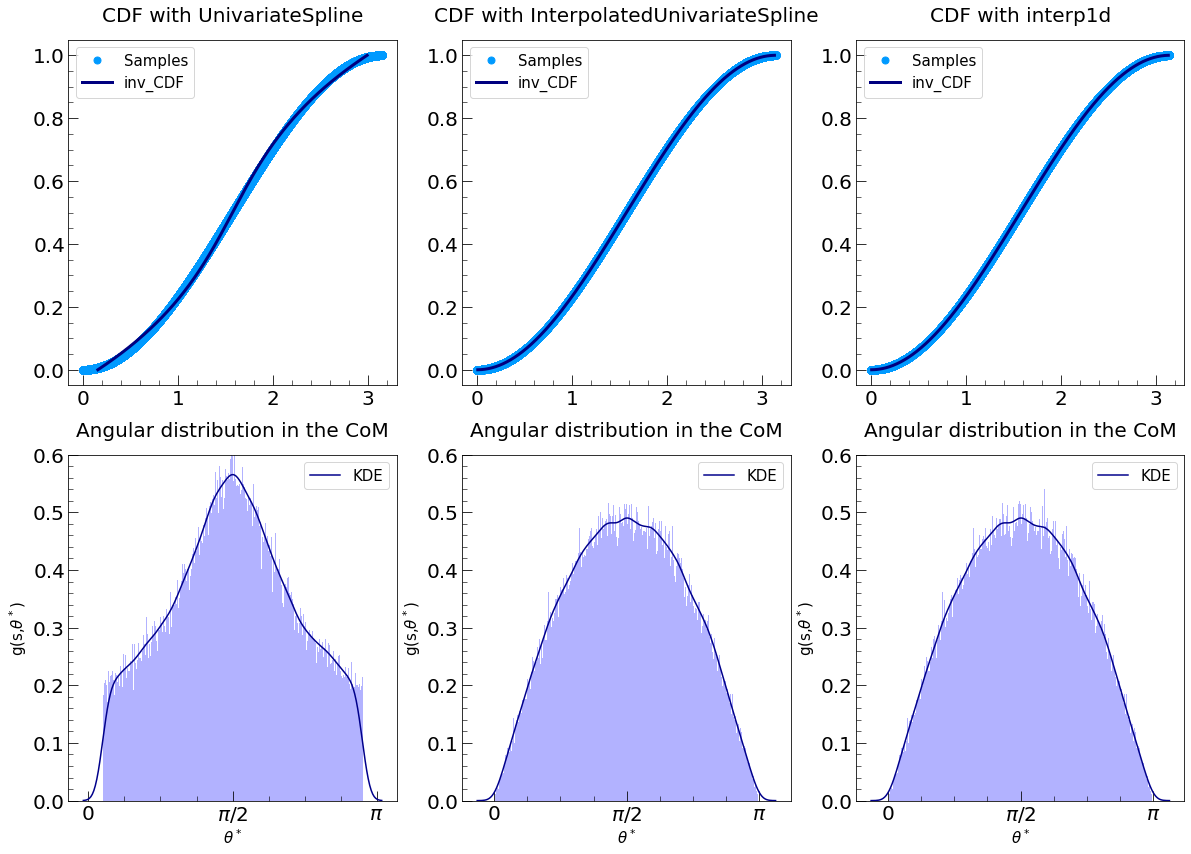

In [203]:
fig, ax = plt.subplots(2,3, figsize = (20,14))

# Angles in the CoM frame on which we sample the inverse CDF
theta_star = np.linspace(0, np.pi, N)

s = sqr_s**2 

# three version of inverse CDF sampling
inv_cdf1 = UnivariateSpline(g_cdf(s,theta_star),theta_star, ext=0)
inv_cdf2 = InterpolatedUnivariateSpline(g_cdf(s,theta_star),theta_star, ext=0)
inv_cdf3 = interp1d(g_cdf(s, theta_star), theta_star, fill_value='extrapolate') #'extrapolate' is needed for the points at z=0,1, which are 'very slightly' outside of the samples
    
# Sample some angles
num_samples = N
unif_samples = np.random.uniform(size=num_samples)
samples_sorted = np.sort(unif_samples)

phis = np.random.uniform(0, 2 * np.pi, size=num_samples)

#same plot on each ax of the points
for i in range(3):
    ax[0][i].plot(theta_star,g_cdf(s,theta_star),'o',markersize= 7,color = '#009AFF',label='Samples')
    ax[1][i].set_title('Angular distribution in the CoM', pad = 18, fontsize=20)
    ax[1][i].set_ylim(0,0.6)
    ax[1][i].set_xticks([0,np.pi/2,np.pi],['0','$\\pi/2$','$\\pi$'] )
    ax[1][i].set_xlabel('$\\theta^*$',fontsize = 15)
    ax[1][i].set_ylabel('g(s,$\\theta^*$)',fontsize = 15)   


### UnivariateSpline ###
ax[0][0].set_title('CDF with UnivariateSpline', pad = 18, fontsize=20)
ax[0][0].plot(inv_cdf1(samples_sorted),samples_sorted,color = 'navy',label = 'inv_CDF',linewidth = 3) 
sns.distplot(inv_cdf1(samples_sorted), ax = ax[1][0],kde = True, kde_kws  = {'label': 'KDE',  'color': 'darkblue'},hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'}, bins = int(np.sqrt(N)))


### InterpolatedUnivariateSpline ###
ax[0][1].set_title('CDF with InterpolatedUnivariateSpline', pad = 18, fontsize=20)
ax[0][1].plot(inv_cdf2(samples_sorted),samples_sorted,color = 'navy',label = 'inv_CDF',linewidth = 3) 
sns.distplot(inv_cdf2(samples_sorted), ax = ax[1][1],kde = True, kde_kws  = {'label': 'KDE',  'color': 'darkblue'},hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'}, bins = int(np.sqrt(N)))

### interp1d ###
ax[0][2].set_title('CDF with interp1d', pad = 18, fontsize=20)
ax[0][2].plot(inv_cdf3(samples_sorted),samples_sorted,color = 'navy',label = 'inv_CDF',linewidth = 3) 
sns.distplot(inv_cdf3(samples_sorted), ax = ax[1][2],kde = True, kde_kws  = {'label': 'KDE',  'color': 'darkblue'},hist_kws = { 'color': 'blue', 'alpha': 0.3,'linewidth': 1,  'histtype':'barstacked'},bins = int(np.sqrt(N)))

for ax in fig.get_axes():
    # plot settings                    
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=15)
    
plt.show()


Different interpolating functions lead to different distribution: in particular the ``InterpolatedUnivariateSpline``method is not able to fit the extremes providing a wrong angular distribution. 
We then decide to use the ``interp1d`` method. 

In order to generate the scattering events we definie a routine that is implemented in the function `generate_beam`, which returns the two muons 3-momenta in the laboratory frame. 

In [185]:
def generate_beam(sqr_s, batch_size = 10**5):
    '''Function that generates one batch of scattering events
    
    Parameters:

    sqr_s : float
           Center of mass energy (sqrt(s)) in MeV (must be > 2 mu)
           
    batch_size : int, optional
                 Number of events to generate in one batch
                       
    Returns:

    batch : ndarray of size (batch_size, 6)
            Each row is one event, and contains the components of the 3-momenta (in the laboratory frame)
            of the muon-antimuon pair, in [MeV/c]
    '''
    
    assert sqr_s > 2 * mu, 'There is not enough energy for muon pair production'
    s = sqr_s**2 

    pnorm = norm(s) # Norm of muon 3-momentum in CM
    
    # Compute inverse CDF of g(theta*) by interpolation 
    theta_star = np.linspace(0, np.pi, N)
    inv_cdf = interp1d(g_cdf(s, theta_star), theta_star, fill_value='extrapolate')

    # Sample angles
    num_samples = N
    unif_samples = np.random.uniform(size=batch_size)

    phis = np.random.uniform(0, 2 * np.pi, size=batch_size)
    thetas = inv_cdf(unif_samples)
    
    
    # Compute cartesian components of 3-vector
    px_cm = pnorm * np.cos(thetas)
    py_cm = pnorm * np.sin(thetas) * np.cos(phis)
    pz_cm = pnorm * np.sin(thetas) * np.sin(phis)


    def gamma_e(s):
        return 1 / np.sqrt(1 - b_me(s)**2)
    

    def energy_x_boost(s, x_cm):

        E_cm  = np.sqrt(s) / 2
        gamma = gamma_e(s)
        beta  = b_me(s)
        
        return (gamma * ( E_cm + beta * x_cm ), gamma * (beta * E_cm + x_cm))

    _,px1 = energy_x_boost(s, px_cm)  # px for first muon
    _,px2 = energy_x_boost(s, -px_cm) # px for second muon
    # py and pz are orthogonal to boost axis, and so they remain the same
    
    return np.stack((px1, py_cm, pz_cm, px2, -py_cm, -pz_cm), axis=1)    




In [196]:
# generate events 
events = generate_beam(250, 10**5)
# save events in txt file and dataframe 
np.savetxt("Momenta_monochromatic.txt", events) # save to file
df_monochromatic = pd.DataFrame(events, columns = [  '$px_{\mu_1}$','$py_{\mu_1}$','$pz_{\mu_1}$','$px_{\mu_2}$','$py_{\mu_2}$','$pz_{\mu_2}$'])
df_monochromatic.to_csv('Events.csv')
df_monochromatic

,$px_{\mu_1}$,$py_{\mu_1}$,$pz_{\mu_1}$,$px_{\mu_2}$,$py_{\mu_2}$,$pz_{\mu_2}$
0,20089.983233,37.656782,-34.717840,41064.230252,-37.656782,34.717840
1,25706.915394,-35.566723,-52.914418,35447.298091,35.566723,52.914418
2,28720.204471,60.218889,-27.881353,32434.009014,-60.218889,27.881353
3,40638.905749,44.081905,-28.743812,20515.307736,-44.081905,28.743812
4,40369.037393,33.518284,41.659153,20785.176092,-33.518284,-41.659153
...,...,...,...,...,...,...
99995,29383.768955,-2.536634,66.566319,31770.444530,2.536634,-66.566319
99996,30722.042295,17.464614,64.466611,30432.171190,-17.464614,-64.466611
99997,17897.562542,30.087602,-29.483789,43256.650943,-30.087602,29.483789
99998,41844.675289,-16.224040,45.567594,19309.538196,16.224040,-45.567594


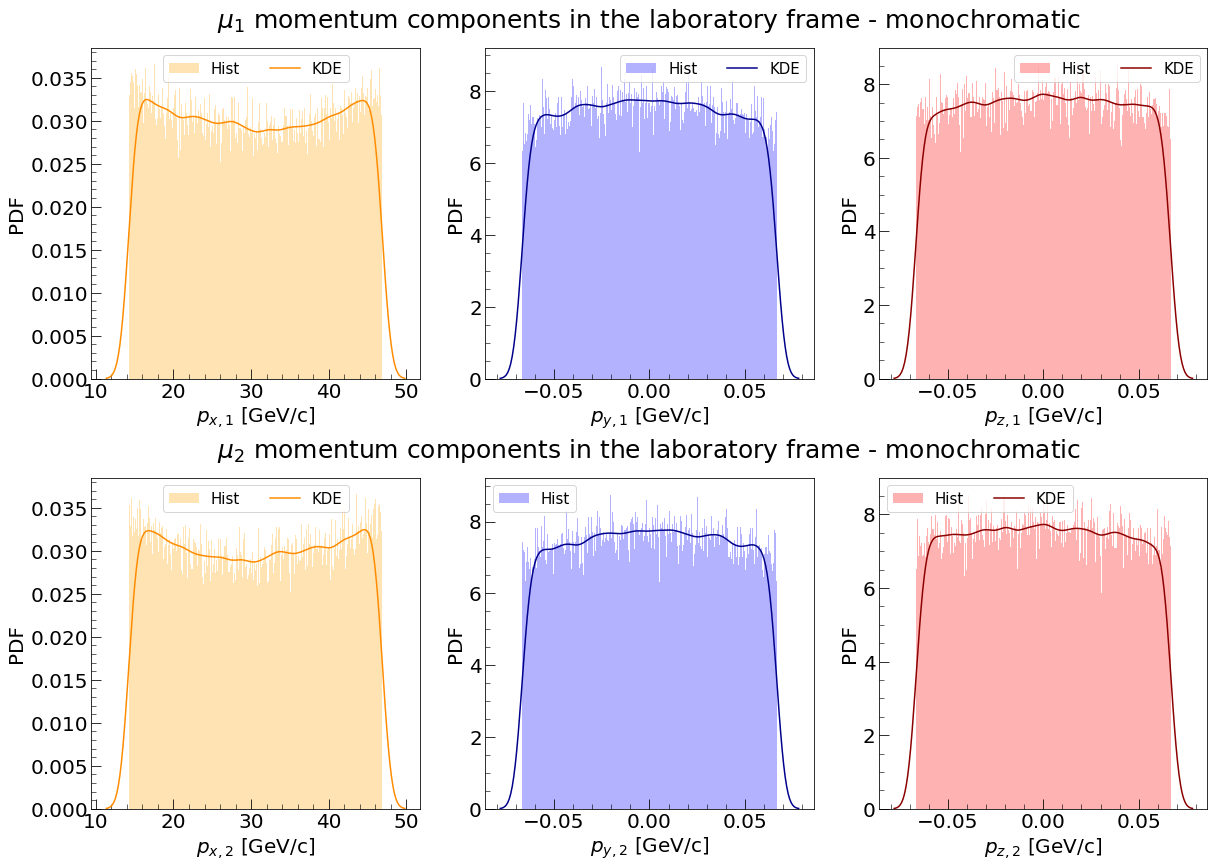

In [236]:
fig, ax = plt.subplots(2,3, figsize = (20,14))

#plotting momentum components distribution in the LAB frame


### MUON 1 ###
# px
sns.distplot(df_monochromatic['$px_{\mu_1}$']/1000,
             ax = ax[0][0],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkorange',   'label': 'KDE'},
             hist_kws = {'color': 'orange', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )

            
# py
sns.distplot(df_monochromatic['$py_{\mu_1}$']/1000,
             ax = ax[0][1],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkblue',   'label': 'KDE'},
             hist_kws = {'color': 'blue', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )
            
# pz
sns.distplot(df_monochromatic['$pz_{\mu_1}$']/1000,
             ax = ax[0][2],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkred',   'label': 'KDE'},
             hist_kws = {'color': 'red', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
            )


ax[0][0].set_xlabel(r'$p_{x,1}$ [GeV/c]',fontsize = 20)
ax[0][1].set_xlabel(r'$p_{y,1}$ [GeV/c]',fontsize = 20)
ax[0][2].set_xlabel(r'$p_{z,1}$ [GeV/c]',fontsize = 20)

ax[0][1].set_title('$\mu_1$ momentum components in the laboratory frame - monochromatic',fontsize = 25,pad = 20)


### MUON 2 ###
# px
sns.distplot(df_monochromatic['$px_{\mu_2}$']/1000,
             ax = ax[1][0],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkorange',   'label': 'KDE'},
             hist_kws = {'color': 'orange', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )

#sns.histplot(
#    x           = df_monochromatic['$px_{\mu_2}$']/1000,
#    stat        = "count",
#    element     = "poly",
#    fill        = True,
#    lw          = 2,
#    kde         = True,
#    #kde_kws  = dict(color = 'darkblue'),
#    edgecolor   = "#009CFF",
#    color       = "#ccebff",
#    label       = "Hist",
#    ax=ax[1][0]
#)

            
# py
sns.distplot(df_monochromatic['$py_{\mu_2}$']/1000,
             ax = ax[1][1],
             bins = int(np.sqrt(N)),
             kde = True,
             color = 'darkblue',
             hist_kws = {'color': 'blue', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
             )
            
# pz
sns.distplot(df_monochromatic['$pz_{\mu_2}$']/1000,
             ax = ax[1][2],
             bins = int(np.sqrt(N)),
             kde = True,
             kde_kws  = {'color': 'darkred',   'label': 'KDE'},
             hist_kws = {'color': 'red', 'alpha': 0.3, 'linewidth': 1, 'histtype':'barstacked', 'label': 'Hist'}
            )


ax[1][0].set_xlabel(r'$p_{x,2}$ [GeV/c]',fontsize = 20)
ax[1][1].set_xlabel(r'$p_{y,2}$ [GeV/c]',fontsize = 20)
ax[1][2].set_xlabel(r'$p_{z,2}$ [GeV/c]',fontsize = 20)

ax[1][1].set_title('$\mu_2$ momentum components in the laboratory frame - monochromatic',fontsize = 25, pad = 20)

for ax in fig.get_axes():
    # plot settings   
    ax.set_ylabel('PDF',fontsize = 20)                   
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 10, labelsize = 20)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 5)
    ax.minorticks_on()
    ax.legend(loc='best', fontsize=15, ncol = 2)


plt.subplots_adjust(hspace=.3)
plt.show()



# Berilium target 

<AxesSubplot:xlabel='$px_{\\mu_1}$', ylabel='Count'>

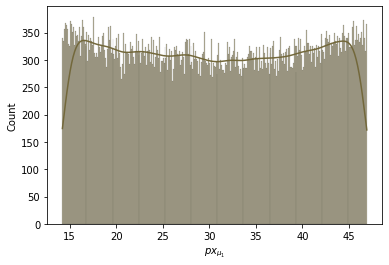